## Step 6: Treecode

In the previous notebooks, we dicussed the upward sweep (M2M: multipole to multipole) based on the tree structure. We have the multipole for every cell in the tree. it is time to evaluate the potential at each target point using treecode. 

##### Potential Evaluation

Based on the tree structure, we distribute each particle in a certain twig cell, so that when we consider the influence of source points, we no longer need to loop in each source particle, instead we should loop in each cell. An efficient way to go over every cell is to do a traverse from the root cell to the leafs. Considering we are traversing the tree to calculate the potential of a certain target particle $i$: if the current cell is in 'near' to particle $i$, we will use direct summation to calculate this near-field contribution; while if the current cell is relatively 'far' to particle $i$, then we evaluate the far-field effect using multipole expansion. So the next question is how can we distinguish between 'near' and 'far' ?

Barnet and Hut firstly introduced this criterion in their paper published in 1986:

- near field: $$\frac{l_{cell}}{d} > \theta $$ 

- far field: $$\frac{l_{cell}}{d} \leq \theta $$

$r_{cell}$ denotes the length of current cell, $d$ is the distance between the target point and the center of the cell, and $\theta$ is the tolerance parameter, a fixed value around 1. Recall in our cell data structure, we use radius of a cell rather than length ($l_{cell} = 2r_{cell}$). Thus, the criterion applied in our treecode can be written as:

- near field: $$ r_{cell} > \theta \cdot d$$

- far field: $$ r_{cell} \leq \theta \cdot d$$

where $\theta$ is around 0.5.

<img src="image/potential_eval.png">

The figure above shows the flowchart of potential evaluation module. For each target particle $i$, we traverse from the root cell. If the current cell is a twig, then we use direct summation to add the cell's contribution to the potential. If not, we use the criterion metioned above to identify whether the current cell is in near-field or far-field. For a far-field non-twig cell, we apply multipole expansion to accumulate into the potential. For a near-field non-twig cell, we need to recursively traverse down to twig cells, in order to go over each source particles located in these near-field twig cells to perform direct summation.

In [1]:
def evaluate(particles, p, i, cells, n_crit, theta):
    """Evaluate the gravitational potential at target point i, caused by source particles cell p. If leaf number of cell p is less than n_crit (twig), use direct summation. Otherwise (non-twig), loop in p's child cells. If child cell c is in far-field of target particle i, use multipole expansion. Otherwise (near-field), call the function recursively.
    
    Arguments:
        particles: the list of particles
        p: cell index in cells list
        i: target particle index
        cells: the list of cells
        n_crit: maximum number of leaves in a single cell
        theta: tolerance parameter    
    """
    # non-leaf cell
    if cells[p].nleaf >= n_crit:
        # loop in p's child cells (8 octants)
        for octant in range(8):
            if cells[p].nchild & (1 << octant):
                c = cells[p].child[octant]
                r = particles[i].distance(cells[c])
                # near-field child cell
                if cells[c].r > theta*r:
                    evaluate(particles, c, i, cells, n_crit, theta)
                # far-field child cell
                else:
                    dx = particles[i].x - cells[c].x
                    dy = particles[i].y - cells[c].y
                    dz = particles[i].z - cells[c].z
                    r3 = r**3
                    r5 = r3*r**2
                    # calculate the weight for each multipole
                    weight = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
                              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
                              3*dy*dz/r5, 3*dz*dx/r5]
                    particles[i].phi += numpy.dot(cells[c].multipole, weight)
                
    # leaf cell
    else:
        # loop in twig cell's particles
        for l in range(cells[p].nleaf):
            source = particles[cells[p].leaf[l]]
            r = particles[i].distance(source)
            if r != 0:
                particles[i].phi += source.m / r

In [2]:
def eval_potential(particles, cells, n_crit, theta):
    for i in range(len(particles)):
        evaluate(particles, 0, i, cells, n_crit, theta)

The above section is the last module in the treecode. We introduce the criterion to compare $r_{cell}$ with $\theta \cdot r$. A bigger $\theta$ implies a less strict requirement of "far-field", therefore, a bigger $\theta$ will bring about a greater calculation error. On the contrary, a smaller $\theta$ indicates a more accurate solution. 

##### Final Treecode

In notebook 1, we talked about the direct summation, which is our knowledge before this tutorial. Then we elaborated how to formulate multipole expansion in notebook 2 & 3, and call it particle to multipole (P2M). In notebook 4, we introduced the cell class, and based on which we generate the tree structure using a list. In the previous one, we covered the upward sweep, by which a parent cell's multipole can be evaluated by traversing over its child cells, and that is why we name it as multipole to multipole (M2M). We just went over the potential evaluation module. Now it is time to integrate these modules into our final treecode. Each function we defined before has been added to the python script (treecode.py).

Before the code, we redeclare the problem statement and the assumptions: there are plenty of particles randomly scattering in domain $x$, $y$, $z$ $\in$ $\left[ 0, 1 \right]$, we assume they have the same mass and the total mass is equal to 1.

In [3]:
import numpy
import time
from treecode_helper import *
from matplotlib import pyplot, rcParams
%matplotlib inline

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

In [4]:
n_crit = 10      # max number of particles in a single cell
theta = 0.5      # a parameter to determine far-field or near-field

In [5]:
# read particles from input file
particles = read_particle('cube1000')
# or generate a randomly distributed particles in a cube
# n = 1000   # number of particles
# particles = [ Particle(m=1.0/n) for i in range(n) ]

We first calculate the potentials using direct summation method. 

In [6]:
# direct summation
tic = time.clock()
direct_sum(particles)
toc = time.clock()

time_direct = toc - tic
phi_direct = numpy.asarray([particle.phi for particle in particles])

In [7]:
# reset the potential at each target
for particle in particles:
    particle.phi = 0.

Then it's time for treecode, and we call `time.clock()` function before and after each module in order to study the breakdown of computation time.

In [8]:
# build tree
tic = time.clock()
root = Cell(n_crit)
root.x, root.y, root.z = 0.5, 0.5, 0.5
root.r = 0.5
cells = build_tree(particles, root, n_crit)
toc = time.clock()

time_src = toc - tic

In [9]:
# P2M: particle to multipole
tic = time.clock()
leaves = []
get_multipole(particles, 0, cells, leaves, n_crit)
toc = time.clock()

time_P2M = toc - tic

In [10]:
# M2M: multipole to multipole (upward translation)
tic = time.clock()
upward_sweep(cells)
toc = time.clock()

time_M2M = toc - tic

In [11]:
# evaluate potential
tic = time.clock()
eval_potential(particles, cells, n_crit, theta)
toc = time.clock()

time_eval = toc - tic
phi_tree = numpy.asarray([particle.phi for particle in particles])

In [12]:
time_tree = time_src + time_P2M + time_M2M + time_eval

##### Error Analysis

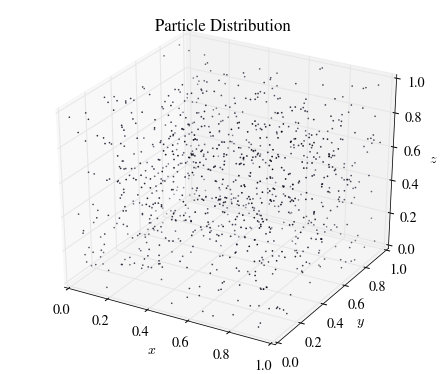

In [13]:
# plot particle distribution
fig = pyplot.figure(figsize=(6,5))
ax = Axes3D(fig)
scale = 0.3   # scale for dot size in scatter plot
ax.scatter([particle.x for particle in particles], 
           [particle.y for particle in particles], 
           [particle.z for particle in particles],
           s=numpy.array([particle.phi for particle in particles])*scale, c='b')
ax.set_xlim3d(0,1)
ax.set_ylim3d(0,1)
ax.set_zlim3d(0,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution');

We calculate the relative error for each target particle, and use $L^2$ norm (Euclidean norm) to evaluate the overall error. The following scatter plots shows the magnitude of relative error of each particle's potential.

In [14]:
# l2 norm error
l2_err(phi_direct, phi_tree)

L2 Norm error: 0.001838923708831628


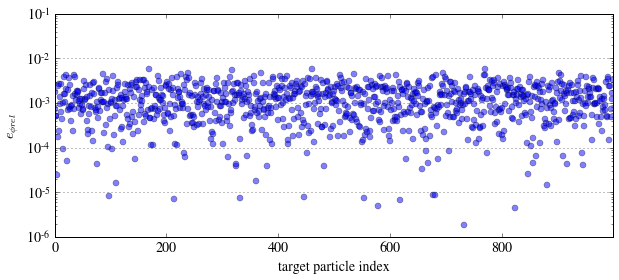

In [15]:
# plot error band
plot_err(phi_direct, phi_tree)

Recall the tolerance parameter $\theta$, which strongly affects the level of treecode accuracy. A larger $\theta$ means less strict definition of "far-field", thus giving rise to a greater error. To verify this trend, here we perform a parameter study by giving a set of $\theta$ decreasing from 0.5 to 0.1 (using particle input file `cube1000`, critical number $n_{crit}$  = 10).

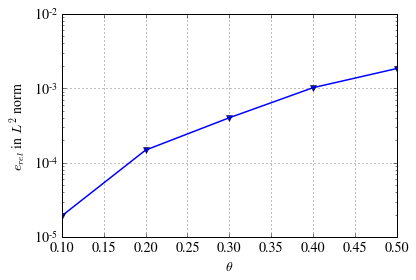

In [16]:
# result from 'cube1000'
theta_set = numpy.linspace(0.5, 0.1, 5)
err_set = [0.001838923708831628, 0.0010167619132821818, 0.00040105626486621707, 0.00014748514239285393, 1.9299837098428704e-05]
pyplot.figure(figsize=(6,4))
pyplot.plot(theta_set, err_set, '-bv', linewidth=1.5, markersize=6)
pyplot.xlabel(r'$\theta$')
pyplot.ylabel(r'$e_{rel}$ in $L^2$ norm')
pyplot.grid("on")
pyplot.yscale('log');

The figure above illustrates that the $L^2$ norm error increases as the tolerance parameter $\theta$ goes up. Note that when $\theta$ approaches to 0, no particle is considered in the far-field, therefore, the treecode is drawing near to direct summation.

##### Computational Cost & Scalability

As we stated in the first notebook, the main benefit we can gain from treecode is shortening the computation time. In the code, we add time.clock() function to measure the time elapsing in different modules: tree construction, P2M, M2M and potential evaluation. Let us visualize it and compare to the direct summation time. 

In [17]:
print("The speedup of treecode: %f" % (time_direct/time_tree))

The speedup of treecode: 3.448254


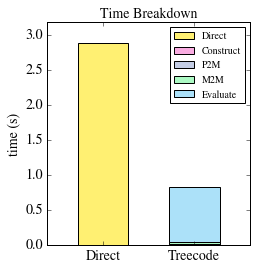

In [18]:
times = [time_direct, time_src, time_P2M, time_M2M, time_eval]
palettes = ['#fff072', '#f9ace1', '#c4cde5', '#acf9c4', '#ace1f9']
labels = ['Direct', 'Construct', 'P2M', 'M2M', 'Evaluate']
width = 0.6

pyplot.figure(figsize=(8,4))
pyplot.subplot(1, 2, 1)
pyplot.bar(0.6*width, times[0], width, color=palettes[0], label=labels[0])
for i in range(1,5):
    pyplot.bar(2.4*width, times[i], width, color=palettes[i], label=labels[i], bottom=sum(times[1:i]))
pyplot.xlim([0, 4*width])
pyplot.ylim([0, 1.1*time_direct])
pyplot.xticks([1.1*width, 2.9*width], ('Direct', 'Treecode'))
pyplot.ylabel('time (s)')
pyplot.legend(loc='upper right', prop={'size':10})
pyplot.title("Time Breakdown", fontsize=14)
pyplot.show();

In [19]:
print("build tree: %.4f %%" % (time_src/time_tree))
print("P2M       : %.4f %%" % (time_P2M/time_tree))
print("M2M       : %.4f %%" % (time_M2M/time_tree))
print("eval phi  : %.4f %%" % (time_eval/time_tree))

build tree: 0.0184 %
P2M       : 0.0137 %
M2M       : 0.0267 %
eval phi  : 0.9411 %


The "potential evaluation" module accounts for the majority of computation time. That is because treecode still has to use direct summation method to evaluate the near-field contribution to potentials. The second time-consuming module is "tree construction" module. These two modules both require looping in every target particle $i$, which is the main reason for their big shares in the pie.

When the scale of the problem keeps growing, the speedup of treecode gradually increases. Change the number of particles $n$ in the code to see what happens to the bar chart.

Then we want to look at the scaling profile of treecode. We run the code using a range of particle number $n$ from 100 to 100000. (using particle input files `cube100`, `cube1000`, `cube10000`, `cube100000`, $\theta$ = 0.5, $n_{crit}$ = 10)

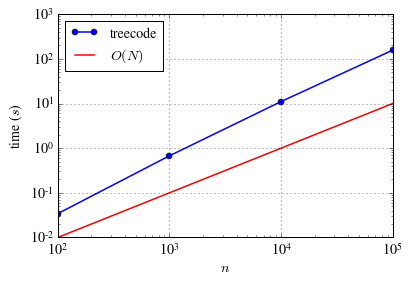

In [20]:
# scaling
n_set = [1e2, 1e3, 1e4, 1e5]
time_elapse = [0.034210, 0.674079, 11.048593, 156.611185]
pyplot.figure(figsize=(6,4))
pyplot.loglog(n_set, time_elapse, '-bo', linewidth=1.5, markersize=6, label='treecode')
pyplot.loglog(n_set, numpy.array(n_set)/10000, '-r', linewidth=1.5, label='$O(N)$')
pyplot.xlabel('$n$')
pyplot.ylabel('time ($s$)')
pyplot.legend(loc='best', fontsize=14)
pyplot.grid("on");

The figure above represents the scaling profile of treecode computation time. The total calculation time of treecode (blue line) increases superlinearly ($O \left( N \log N \right) $) with the scale of problem (the number of particles $n$). The red line represents a linear computational complexity. 

##### Challenge

- Draw the speedup profile based on the computation time of direct summation method. ($\theta$ = 0.5, $n_{crit}$ = 10)

- Make a parameter study of $n_{crit}$, how does it affect the speed of treecode and the accuracy? 

##### Reference

1. 12 Steps to a Fast Multipole Method on GPUs, R. Yokota, Pan-American Advanced Studies Institute, Valparaiso, Chile, 3-14 January, 2011.
2. Pfalzner, Susanne, and Paul Gibbon. Many-body tree methods in physics. Cambridge University Press, 2005.
3. Barnes, Josh, and Piet Hut. "A hierarchical O (N log N) force-calculation algorithm." (1986): 446-449. 

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./style/fmmstyle.css', 'r').read()
    return HTML(styles)
css_styling()